In [1]:
import nibabel as nb
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np 

import torch 
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from datetime import datetime

import utils

In [2]:
#Unet CLASICA (nuevo formato)

class DownConv(nn.Module):
    
    def __init__(self, in_channels , out_channels):
        super(DownConv, self).__init__()
        self.DownLayer = nn.Sequential(

            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace = True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace = True),
        )
        
    def forward(self, x ):
        x = self.DownLayer(x)
        return x
    
        
class MaxPool(nn.Module):
    def __init__(self):
        super(MaxPool, self).__init__()
        self.Pool = torch.nn.MaxPool2d(kernel_size = 2)
        
    def forward (self,x):
        x = self.Pool(x)
        return x
    
        
class UpConv(nn.Module):
    
    def __init__(self, in_channels , out_channels):
        super(UpConv, self).__init__()
        
        self.ConvTransp = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        #self.ConvTransp = torch.nn.ConvTranspose2d((in_channels//2), out_channels, kernel_size = 2, stride = 2, padding = 0)
        self.UpConv = DownConv(in_channels, out_channels)
        
    def forward(self, xAnt , xDown):
            
        layerConvTransposed = self.ConvTransp(xAnt)
        concat = torch.cat([layerConvTransposed,xDown], dim=1)
        x = self.UpConv(concat)
            
        return x

class OutUnet(nn.Module):
    def __init__(self, in_channels , out_channels):
        super(OutUnet, self).__init__()
        self.OutUnet = torch.nn.Conv2d(in_channels,out_channels, kernel_size = 1)
        
    def forward(self,x):
        x = self.OutUnet(x)
        return x

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet,self).__init__()
        
        # Contract
        self.Layer1Down = DownConv(1,32)
        self.Layer2Down = DownConv(32,64)
        self.Layer3Down = DownConv(64,128)
        self.Layer4Down = DownConv(128,256)
        self.Layer5Down = DownConv(256,512)
        
        self.Middle = DownConv(512,512)
        
        self.Layer1Up = UpConv(1024,256)
        self.Layer2Up = UpConv(512,128)
        self.Layer3Up = UpConv(256,64)
        self.Layer4Up = UpConv(128,64)
        self.Layer5Up = UpConv(64+32,32)
        
        self.MaxPool = MaxPool()
        
        self.Out = OutUnet(32,1)
        
        
    
    def forward(self, x):

        # Down
        conv1 = self.Layer1Down(x)
        maxPool1 = self.MaxPool(conv1)
        
        conv2 = self.Layer2Down(maxPool1)
        maxPool2 = self.MaxPool(conv2)
        
        conv3 = self.Layer3Down(maxPool2)
        maxPool3 = self.MaxPool(conv3)
        
        conv4 = self.Layer4Down(maxPool3)
        maxPool4 = self.MaxPool(conv4)
        
        conv5 = self.Layer5Down(maxPool4)
        maxPool5 = self.MaxPool(conv5)
        
        middle = self.Middle(maxPool5)
        
        # Up
        up1= self.Layer1Up(middle,conv5)
        up2= self.Layer2Up(up1,conv4)
        up3= self.Layer3Up(up2,conv3)
        up4= self.Layer4Up(up3,conv2)
        up5= self.Layer5Up(up4,conv1)
        
        outUNet = self.Out(up5)
        
        return outUNet

unet = Unet()

In [3]:
def MSE(img1, img2):
    cuadradoDeDif = ((img1 - img2) ** 2)
    suma = np.sum(cuadradoDeDif)
    cantPix = img1.shape[2] * img1.shape[1]  # img1 and 2 should have same shape
    error = suma / cantPix
    return error

In [4]:
# Importo base de datos

noisyDataSet1_nii = sitk.ReadImage('./noisyDataSet1.nii')
img_noisyDataSet1 = sitk.GetArrayFromImage(noisyDataSet1_nii)

noisyDataSet2_nii = sitk.ReadImage('./noisyDataSet2.nii')
img_noisyDataSet2 = sitk.GetArrayFromImage(noisyDataSet2_nii)

groundTruth_nii = sitk.ReadImage('./groundTruth.nii')
img_groundTruth = sitk.GetArrayFromImage(groundTruth_nii)

print("noisyDataSet1 shape:",img_noisyDataSet1.shape)
print("noisyDataSet2 shape:",img_noisyDataSet2.shape)
print("groundTruth shape:",img_groundTruth.shape)

noisyDataSet1 shape: (1726, 344, 344)
noisyDataSet2 shape: (1726, 344, 344)
groundTruth shape: (1726, 344, 344)


In [5]:
# Reshape for training

img_noisyDataSet1 =img_noisyDataSet1[:,44:300,44:300]
img_noisyDataSet2 =img_noisyDataSet2[:,44:300,44:300]
img_groundTruth =img_groundTruth[:,44:300,44:300]


img_noisyDataSet1 = (np.expand_dims(img_noisyDataSet1, axis=-3)).astype(np.float32)
img_noisyDataSet2 = (np.expand_dims(img_noisyDataSet2, axis=-3)).astype(np.float32)
img_groundTruth = (np.expand_dims(img_groundTruth, axis=-3)).astype(np.float32)

print(img_noisyDataSet1.shape)
print(img_noisyDataSet2.shape)
print(img_groundTruth.shape)

(1726, 1, 256, 256)
(1726, 1, 256, 256)
(1726, 1, 256, 256)


In [6]:
# MSE dataset promedio
MSEdataSet1 = []
MSEdataSet2 = []
for i in range(0,img_noisyDataSet1.shape[0]):
    img1 = img_groundTruth[i]
    img2 = img_noisyDataSet1[i]
    img3 = img_noisyDataSet2[i]
    MSEdataSet1.append(MSE(img1,img2))
    MSEdataSet2.append(MSE(img1,img3))

print(np.mean(MSEdataSet1))
print(np.mean(MSEdataSet2))

0.2011082119708667
0.3494163649155729


In [7]:
# Conjunto de entrenamiento, testeo y validacion

train_noisyImage,valid_noisyImage,train_groundTruth,valid_groundTruth = train_test_split(img_noisyDataSet1, img_groundTruth, test_size=0.3)

# Create dictionaries with training sets:
trainingSet = dict([('input',train_noisyImage), ('output', train_groundTruth)])
validSet = dict([('input',valid_noisyImage), ('output', valid_groundTruth)])

print('Data set size. Training set: {0}. Valid set: {1}.'.format(trainingSet['input'].shape[0], validSet['input'].shape[0]))

# Entrenamiento #

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

Data set size. Training set: 1208. Valid set: 518.


In [ ]:
# Entrenamiento #

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

# Codigo entrenamiento Martin

# defino batches

best_vloss = 1000000000

batchSizeTrain = 4
batchSizeValid = 4
numBatchesTrain = np.round(trainingSet['input'].shape[0] / batchSizeTrain).astype(int)
numBatchesValid = np.round(validSet['input'].shape[0] / batchSizeValid).astype(int)

# Show dev set loss every showDevLossStep batches:
showDevLossStep = 4

printStep = 1
# figImages, axs = plt.subplots(3, 1,figsize=(20,20))
# figLoss, axLoss = plt.subplots(1, 1,figsize=(5,5))

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# Train
loss_values = []
lossValuesTrainingSet = []
iterationNumbers = []
lossValuesDevSet = []
iterationNumbersForDevSet = []
lossValuesTrainingSetEpoch = []

lossValuesEpoch = []
lossValuesDevSetAllEpoch = []

iter = 0

EPOCHS = 20

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    
    lossValuesTrainingSetEpoch = []
    lossValuesDevSetEpoch = []

    running_loss = 0.0

    unet.train(True)
    for i in range(numBatchesTrain):
        # get the inputs

        inputs = torch.from_numpy(trainingSet['input'][i * batchSizeTrain:(i + 1) * batchSizeTrain, :, :, :])
        gt = torch.from_numpy(trainingSet['output'][i * batchSizeTrain:(i + 1) * batchSizeTrain, :, :, :])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, gt)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # Save loss values:
        lossValuesTrainingSet.append(loss.item())
        lossValuesTrainingSetEpoch.append(loss.item())
        iterationNumbers.append(iter)

        if i % printStep == (printStep - 1):  # print every printStep mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0

            # Show input images:
            # plt.figure(figImages)
            # plt.axes(axs[0])
            # imshow(torchvision.utils.make_grid(inputs, normalize=True))
            # axs[0].set_title('Input Batch {0}'.format(i))
            # plt.axes(axs[1])
            # imshow(torchvision.utils.make_grid(outputs, normalize=True))
            # axs[1].set_title('Output Epoch {0}'.format(epoch))
            # plt.axes(axs[2])
            # imshow(torchvision.utils.make_grid(gt, normalize=True))
            # axs[2].set_title('Ground Truth')
            # Show loss:
            # plt.figure(figLoss)
            # axLoss.plot(iterationNumbers, lossValuesTrainingSet)
            # axLoss.plot(iterationNumbersForDevSet, lossValuesDevSet)
            # plt.draw()
            # plt.pause(0.0001)

            # Update iteration number:
        iter = iter + 1

    lossValuesEpoch.append(np.mean(lossValuesTrainingSetEpoch))
    unet.train(False)
    running_vloss = 0.0


    for i in range(numBatchesValid):
        print(i)

        vinputs = torch.from_numpy(validSet['input'][i * batchSizeValid:(i + 1) * batchSizeValid, :, :, :])
        vgt = torch.from_numpy(validSet['output'][i * batchSizeValid:(i + 1) * batchSizeValid, :, :, :])

        voutputs = unet(vinputs)
        vloss = criterion(voutputs, vgt)
        vloss.backward()
        running_vloss += vloss

        lossValuesDevSet.append(vloss.item())
        
        lossValuesDevSetEpoch.append(vloss.item())


    avg_vloss = np.mean(lossValuesDevSet)
    lossValuesDevSetAllEpoch.append(np.mean(lossValuesDevSetEpoch))

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch)
        torch.save(unet.state_dict(), model_path)

    print('LOSS train {} valid {}'.format(llossValuesDevSetAllEpoch[-1], lossValuesEpoch[-1]))
    # CALCULAR PROMEDIO DE TODOS O VARIOS BATCH

print('Finished Training')

[1,     1] loss: 1.194
[1,     2] loss: 0.377
[1,     3] loss: 0.621
[1,     4] loss: 0.353
[1,     5] loss: 0.464
[1,     6] loss: 0.321
[1,     7] loss: 0.279
[1,     8] loss: 0.394
[1,     9] loss: 0.426
[1,    10] loss: 0.328


Text(0, 0.5, 'Loss')

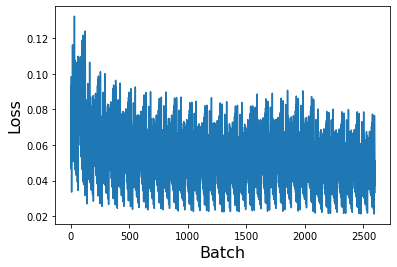

In [10]:
plt.plot(lossValuesDevSet)
plt.xlabel("Batch", size = 16,)
plt.ylabel("Loss", size = 16)

Text(0, 0.5, 'Loss')

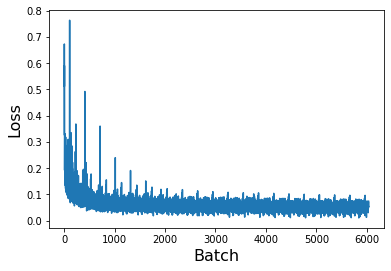

In [11]:
plt.plot(lossValuesTrainingSet)
plt.xlabel("Batch", size = 16,)
plt.ylabel("Loss", size = 16)

Text(0, 0.5, 'Loss')

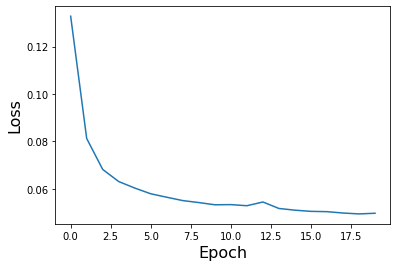

In [12]:
plt.plot(lossValuesEpoch)
plt.xlabel("Epoch", size = 16,)
plt.ylabel("Loss", size = 16)

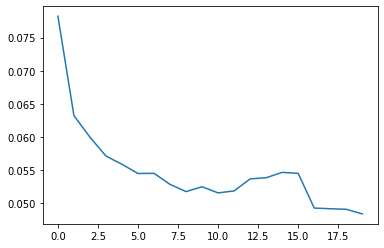

In [13]:
plt.plot(lossValuesDevSetAllEpoch)

In [ ]:
# Test set
# PLANTEAMOS UN CONJUNTO DE TESTEO ROTADO PARA VER LOS RESULTADOS

trainingSet = dict([('input',train_noisyImage), ('output', train_groundTruth)])

inputsTestSet = torch.from_numpy(trainingSet['input'][:,:,:,:])
groundTruthTestSet = torch.from_numpy(trainingSet['output'][:,:,:,:])

inputsTestSet = torchvision.transforms.functional.rotate(inputsTestSet,15)
groundTruthTestSet = torchvision.transforms.functional.rotate(groundTruthTestSet,15)

In [30]:
## Testeo con DataSet Rotado
outArray = []

#for i in range(0,inputsTestSet.shape[0]):
for i in range(0,10):
    inputs =  inputsTestSet[i]
    inputs = torch.unsqueeze(inputs, dim = 0)
    out = unet(inputs)
    outArray.append(out)
    
# MSE antes y dsp

mseBef = []
mseAft = []

# Antes
img1 = torch.unsqueeze(inputsTestSet[9], dim = 0)
img1 = (img1).detach().numpy()

img2 = torch.unsqueeze(groundTruthTestSet[9], dim = 0)
img2 = (img2).detach().numpy()
mseBef.append(MSE(img1[0,:,:],img2[0,:,:]))

# Dsp
imgOut = (outArray[9]).detach().numpy()
mseAft.append(MSE(imgOut[0,:,:],img2[0,:,:]))

print('MSE antes de pasar por la red',mseBef)
print('MSE dsp de pasar por la red',mseAft)

0.21297317780554295
MSE antes de pasar por la red [0.35828256607055664]
MSE dsp de pasar por la red [0.08926944434642792]


In [26]:
# Guardar imagenes (opcional)

img_inputs = sitk.GetImageFromArray(img1[0,:,:])
sitk.WriteImage(img_inputs,'Entrada.nii')

img_inputs = sitk.GetImageFromArray(imgOut[0,:,:])
sitk.WriteImage(img_inputs,'Salida.nii')

img_out = sitk.GetImageFromArray(img2[0,:,:])
sitk.WriteImage(img_out,'groundTruthUnet.nii')

In [47]:
# TESTEO CON dataSet2

# Create dictionaries with training sets:
testDataSet2 = dict([('input',img_noisyDataSet2), ('output', img_groundTruth)])

inputsTestSet2 = torch.from_numpy(testDataSet2['input'][:,:,:,:])
groundTruthTestSet2 = torch.from_numpy(testDataSet2['output'][:,:,:,:])

In [148]:
## Testeo ....
outArray2 = []

#for i in range(0,inputsTestSet.shape[0]):
for i in range(0,40):
    inputs =  inputsTestSet2[i]
    inputs = torch.unsqueeze(inputs, dim = 0)
    out = unet(inputs)
    outArray2.append(out)
    
# MSE antes y dsp

mseBef2 = []
mseAft2 = []

# Antes
img1 = torch.unsqueeze(inputsTestSet2[30], dim = 0)
img1 = (img1).detach().numpy()

img2 = torch.unsqueeze(groundTruthTestSet2[30], dim = 0)
img2 = (img2).detach().numpy()
mseBef2.append(MSE(img1[0,:,:],img2[0,:,:]))

# Dsp
imgOut = (outArray2[30]).detach().numpy()
mseAft2.append(MSE(imgOut[0,:,:],img2[0,:,:]))

print('MSE antes de pasar por la red',mseBef2)
print('MSE dsp de pasar por la red',mseAft2)

MSE antes de pasar por la red [0.6936010122299194]
MSE dsp de pasar por la red [0.3665635585784912]


In [51]:
img_inputs = sitk.GetImageFromArray(img1[0,:,:])
sitk.WriteImage(img_inputs,'EntradaDataSet2.nii')

img_inputs = sitk.GetImageFromArray(imgOut[0,:,:])
sitk.WriteImage(img_inputs,'SalidaDataSet2.nii')

img_out = sitk.GetImageFromArray(img2[0,:,:])
sitk.WriteImage(img_out,'groundTruthUnetDataSet2.nii')

In [189]:
# MSE materia gris y materia blanca #

nroSliceDS1 = 9

nroSliceDS2 = 30

# Antes de pasar por la red

# dataSet1 rotado
greyMatterNoisyDataSet1RotateAntes = inputsTestSet[nroSliceDS1] * ((groundTruthTestSet[nroSlice]==8)*1.0)
whiteMatterNoisyDataSet1RotateAntes = inputsTestSet[nroSliceDS1] * ((groundTruthTestSet[nroSlice]==2)*1.0)

greyMatterNoisyDataSet1RotateDsp = outArray[nroSliceDS1] * ((groundTruthTestSet[nroSlice]==8)*1.0)
whiteMatterNoisyDataSet1RotateDsp = outArray[nroSliceDS1] * ((groundTruthTestSet[nroSlice]==2)*1.0)

# dataSet2
greyMatterNoisyDataSet2Antes = inputsTestSet2[nroSliceDS2] * ((groundTruthTestSet2[nroSliceDS2]==8)*1.0)
whiteMatterNoisyDataSet2Antes = inputsTestSet2[nroSliceDS2] * ((groundTruthTestSet2[nroSliceDS2]==2)*1.0)

greyMatterNoisyDataSet2Dsp = outArray2[nroSliceDS2] * ((groundTruthTestSet2[nroSliceDS2]==8)*1.0)
whiteMatterNoisyDataSet2Dsp = outArray2[nroSliceDS2] * ((groundTruthTestSet2[nroSliceDS2]==2)*1.0)

# Antes y dsp dataSet1

print('DataSet1')

img1 = torch.unsqueeze(greyMatterNoisyDataSet1RotateAntes, dim = 0)
img1 = (img1).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet[nroSliceDS1]==8)*1.0), dim = 0)
img2 = (img2).detach().numpy()

img_inputs = sitk.GetImageFromArray(img1[0,:,:])
sitk.WriteImage(img_inputs,'EntradaDataSet1GM.nii')

img_inputs = sitk.GetImageFromArray(img2[0,:,:])
sitk.WriteImage(img_inputs,'MASKDataSet1GM.nii')

print('Antes GM',MSE(img1[0,:,:],img2[0,:,:]))

img1 = (greyMatterNoisyDataSet1RotateDsp).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet[nroSliceDS1]==8)*1.0), dim = 0)
img2 = (img2).detach().numpy()

print('Despues GM',MSE(img1[0,:,:],img2[0,:,:]))

img1 = torch.unsqueeze(whiteMatterNoisyDataSet1RotateAntes, dim = 0)
img1 = (img1).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet[nroSliceDS1]==2)*1.0), dim = 0)
img2 = (img2).detach().numpy()

img_inputs = sitk.GetImageFromArray(img1[0,:,:])
sitk.WriteImage(img_inputs,'EntradaDataSet1WM.nii')

img_inputs = sitk.GetImageFromArray(img2[0,:,:])
sitk.WriteImage(img_inputs,'MASKDataSet1WM.nii')

print('Antes WM',MSE(img1[0,:,:],img2[0,:,:]))


img1 = (whiteMatterNoisyDataSet1RotateDsp).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet[nroSliceDS1]==2)*1.0), dim = 0)
img2 = (img2).detach().numpy()

print('Despues WM',MSE(img1[0,:,:],img2[0,:,:]))


# Antes y dsp dataSet2

print('DataSet2')

img1 = torch.unsqueeze(greyMatterNoisyDataSet2Antes, dim = 0)
img1 = (img1).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet2[nroSliceDS2]==8)*1.0), dim = 0)
img2 = (img2).detach().numpy()

print('Antes GM',MSE(img1[0,:,:],img2[0,:,:]))

img1 = (greyMatterNoisyDataSet2Dsp).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet2[nroSliceDS2]==8)*1.0), dim = 0)
img2 = (img2).detach().numpy()

print('Despues GM',MSE(img1[0,:,:],img2[0,:,:]))

img1 = torch.unsqueeze(whiteMatterNoisyDataSet2Antes, dim = 0)
img1 = (img1).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet2[nroSliceDS2]==2)*1.0), dim = 0)
img2 = (img2).detach().numpy()

img_inputs = sitk.GetImageFromArray(img1[0,:,:])
sitk.WriteImage(img_inputs,'EntradaDataSet2WM.nii')

img_inputs = sitk.GetImageFromArray(img2[0,:,:])
sitk.WriteImage(img_inputs,'MASKDataSet2WM.nii')

print('Antes WM',MSE(img1[0,:,:],img2[0,:,:]))

img1 = (whiteMatterNoisyDataSet2Dsp).detach().numpy()
img2 = torch.unsqueeze(((groundTruthTestSet2[nroSliceDS2]==2)*1.0), dim = 0)
img2 = (img2).detach().numpy()

img_inputs = sitk.GetImageFromArray(img1[0,:,:])
sitk.WriteImage(img_inputs,'EntradaDataSet2WM.nii')

img_inputs = sitk.GetImageFromArray(img2[0,:,:])
sitk.WriteImage(img_inputs,'MASKDataSet2WM.nii')

print('Despues WM',MSE(img1[0,:,:],img2[0,:,:]))

DataSet1
Antes GM 1.7985076904296875
Despues GM 1.327314853668213
Antes WM 0.058013916015625
Despues WM 0.049223802983760834
DataSet2
Antes GM 2.1640639305114746
Despues GM 1.446186900138855
Antes WM 0.16540521383285522
Despues WM 0.1953027844429016
